In [425]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import log_loss

In [415]:
# Data Preprocessing

df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv', index_col='Person ID')
df[['Blood Pressure_high', 'Blood Pressure_low']] = df['Blood Pressure'].str.split('/', expand=True)
df.drop(columns=['Blood Pressure'], inplace=True)
df['Blood Pressure_high'] = pd.to_numeric(df['Blood Pressure_high'], errors='coerce')
df['Blood Pressure_low'] = pd.to_numeric(df['Blood Pressure_low'], errors='coerce')
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

occ_counts = df['Occupation'].value_counts()
low_occ = occ_counts[occ_counts < 5].index
mask = df['Occupation'].isin(low_occ)
df.loc[mask, 'Occupation'] = 'Other'

df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Blood Pressure_high,Blood Pressure_low
Person ID,,,,,,,,,,,,,
1,Male,27,Other,6.1,6,42,6,Overweight,77,4200,None,126,83
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
4,Male,28,Other,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
5,Male,28,Other,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [416]:
# List Feature Importance

df_corr = df.copy()

df_corr["Sleep Disorder"] = df_corr["Sleep Disorder"].map({
    "None": 0,
    "Sleep Apnea": 1,
    "Insomnia": 2
})
cat_cols = df_corr.select_dtypes(include='object').columns

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col])
    label_encoders[col] = le

corr_matrix = df_corr.corr(numeric_only=True)

target = "Sleep Disorder"
correlations_with_target = corr_matrix[[target]].drop(index=target)

correlation_table = correlations_with_target.copy()
correlation_table["Abs Correlation"] = correlation_table[target].abs()

correlation_table = correlation_table.sort_values(by="Abs Correlation", ascending=False)

correlation_table = correlation_table.drop(columns="Abs Correlation")

display(correlation_table)

,Sleep Disorder
BMI Category,0.720384
Occupation,0.609179
Blood Pressure_high,0.539280
Blood Pressure_low,0.523490
Sleep Duration,-0.382045
Quality of Sleep,-0.357477
Age,0.303962
Heart Rate,0.220913
Stress Level,0.181296
Daily Steps,-0.161275


In [417]:
# Label Encoding

y_insomnia = df["Sleep Disorder"].apply(lambda x: 1 if x == "Insomnia" else 0)
y_apnea = df["Sleep Disorder"].apply(lambda x: 1 if x == "Sleep Apnea" else 0)

numeric_cols = [
    'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
    'Stress Level', 'Heart Rate', 'Daily Steps', 'Blood Pressure_high', 'Blood Pressure_low'
]
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col])
    label_encoders[col] = le
    df[col] = le.transform(df[col])

for col in categorical_cols:
    encoded_values = df[col].unique()
    decoded_values = label_encoders[col].inverse_transform(encoded_values)

    print(f"\n{col}")
    print("Encoded values:", encoded_values)
    print("Decoded values:", decoded_values)


Gender
Encoded values: [1 0]
Decoded values: ['Male' 'Female']

Occupation
Encoded values: [5 1 7 4 2 0 3 6]
Decoded values: ['Other' 'Doctor' 'Teacher' 'Nurse' 'Engineer' 'Accountant' 'Lawyer'
 'Salesperson']

BMI Category
Encoded values: [2 0 1]
Decoded values: ['Overweight' 'Normal' 'Obese']

Sleep Disorder
Encoded values: [1 2 0]
Decoded values: ['None' 'Sleep Apnea' 'Insomnia']


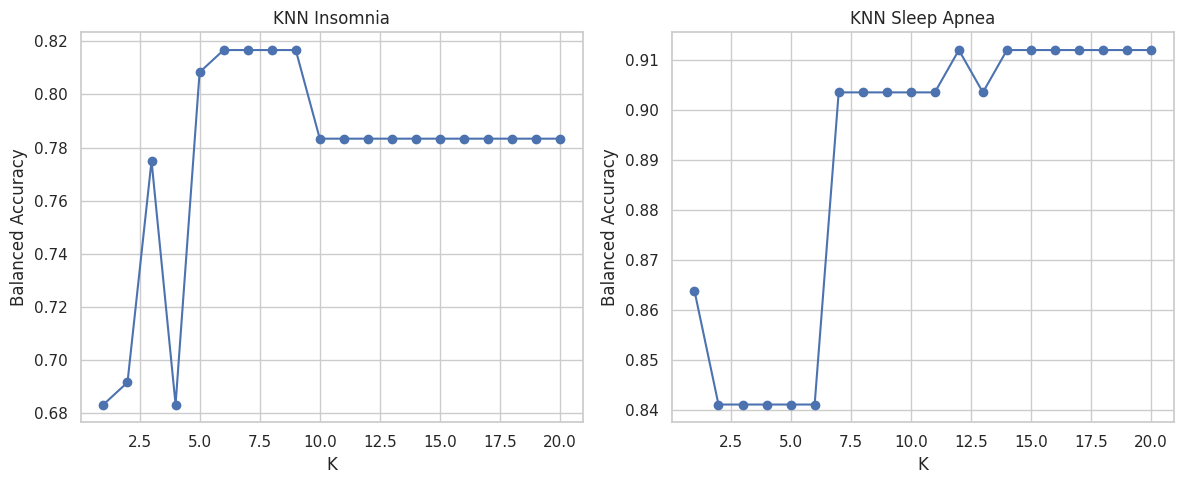

In [418]:
# Find Optimal Value for K in KNN

selected_features = ["BMI Category", "Occupation", "Blood Pressure_high", "Blood Pressure_low", "Sleep Duration", "Quality of Sleep", "Age"]
X = df[selected_features]

X_train_ins, X_test_ins, y_train_ins, y_test_ins = train_test_split(X, y_insomnia, test_size=0.2, random_state=42, stratify=y_insomnia)
X_train_apn, X_test_apn, y_train_apn, y_test_apn = train_test_split(X, y_apnea, test_size=0.2, random_state=42, stratify=y_apnea)

k_values = range(1, 21)
ins_acc_scores = []
apn_acc_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_ins, y_train_ins)
    preds = knn.predict(X_test_ins)
    ins_acc_scores.append(balanced_accuracy_score(y_test_ins, preds))

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_apn, y_train_apn)
    preds = knn.predict(X_test_apn)
    apn_acc_scores.append(balanced_accuracy_score(y_test_apn, preds))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(k_values, ins_acc_scores, marker='o')
axes[0].set_title("KNN Insomnia")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Balanced Accuracy")
axes[0].grid(True)

axes[1].plot(k_values, apn_acc_scores, marker='o')
axes[1].set_title("KNN Sleep Apnea")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Balanced Accuracy")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [419]:
# Model Training - Insomnia

knn_insomnia = KNeighborsClassifier(n_neighbors=10)
knn_insomnia.fit(X_train_ins, y_train_ins)

KNeighborsClassifier(n_neighbors=10)

In [420]:
# Model Training - Sleep Apnea

knn_apnea = KNeighborsClassifier(n_neighbors=12)
knn_apnea.fit(X_train_apn, y_train_apn)

KNeighborsClassifier(n_neighbors=12)

In [426]:
# Model Evaluation

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    bal_acc = balanced_accuracy_score(y_test, test_preds)
    cv_acc = cross_val_score(model, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=5).mean()
    loss = log_loss(y_test, model.predict_proba(X_test))

    print(f"{name} Model Evaluation")
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")
    print(f"Balanced Accuracy: {bal_acc:.2f}")
    print(f"CV Accuracy: {cv_acc:.2f}")
    print(f"Log Loss: {loss:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_preds))

evaluate_model(knn_insomnia, X_train_ins, X_test_ins, y_train_ins, y_test_ins, "Insomnia KNN (k=10)")
evaluate_model(knn_apnea, X_train_apn, X_test_apn, y_train_apn, y_test_apn, "Sleep Apnea KNN (k=12)")

Insomnia KNN (k=10) Model Evaluation
Train Accuracy: 0.93
Test Accuracy: 0.89
Balanced Accuracy: 0.78
CV Accuracy: 0.92
Log Loss: 2.52

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        60
           1       0.82      0.60      0.69        15

    accuracy                           0.89        75
   macro avg       0.86      0.78      0.81        75
weighted avg       0.89      0.89      0.89        75

Sleep Apnea KNN (k=12) Model Evaluation
Train Accuracy: 0.93
Test Accuracy: 0.93
Balanced Accuracy: 0.91
CV Accuracy: 0.93
Log Loss: 1.51

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.82      0.88      0.85        16

    accuracy                           0.93        75
   macro avg       0.89      0.91      0.90        75
weighted avg       0.94      0.93      0.93        75



In [422]:
# Test Data (AI-generated)

samples = [
    # None
    {"Age": 25, "Sleep Duration": 8.0, "Quality of Sleep": 9, "Blood Pressure_high": 115, "Blood Pressure_low": 75, "Occupation": "Engineer", "BMI Category": "Normal"},
    {"Age": 28, "Sleep Duration": 7.5, "Quality of Sleep": 8, "Blood Pressure_high": 118, "Blood Pressure_low": 76, "Occupation": "Teacher", "BMI Category": "Normal"},
    {"Age": 30, "Sleep Duration": 7.8, "Quality of Sleep": 9, "Blood Pressure_high": 120, "Blood Pressure_low": 78, "Occupation": "Doctor", "BMI Category": "Normal"},
    {"Age": 32, "Sleep Duration": 8.2, "Quality of Sleep": 9, "Blood Pressure_high": 119, "Blood Pressure_low": 79, "Occupation": "Salesperson", "BMI Category": "Normal"},
    {"Age": 35, "Sleep Duration": 7.6, "Quality of Sleep": 8, "Blood Pressure_high": 117, "Blood Pressure_low": 76, "Occupation": "Lawyer", "BMI Category": "Normal"},
    {"Age": 27, "Sleep Duration": 7.9, "Quality of Sleep": 9, "Blood Pressure_high": 114, "Blood Pressure_low": 74, "Occupation": "Accountant", "BMI Category": "Normal"},
    {"Age": 29, "Sleep Duration": 7.3, "Quality of Sleep": 8, "Blood Pressure_high": 116, "Blood Pressure_low": 75, "Occupation": "Engineer", "BMI Category": "Normal"},
    {"Age": 34, "Sleep Duration": 8.0, "Quality of Sleep": 9, "Blood Pressure_high": 118, "Blood Pressure_low": 77, "Occupation": "Teacher", "BMI Category": "Normal"},
    {"Age": 31, "Sleep Duration": 7.7, "Quality of Sleep": 8, "Blood Pressure_high": 121, "Blood Pressure_low": 79, "Occupation": "Doctor", "BMI Category": "Normal"},
    {"Age": 26, "Sleep Duration": 7.6, "Quality of Sleep": 8, "Blood Pressure_high": 115, "Blood Pressure_low": 76, "Occupation": "Salesperson", "BMI Category": "Normal"},

    # Insomnia
    {"Age": 36, "Sleep Duration": 4.5, "Quality of Sleep": 2, "Blood Pressure_high": 125, "Blood Pressure_low": 82, "Occupation": "Engineer", "BMI Category": "Normal"},
    {"Age": 42, "Sleep Duration": 4.0, "Quality of Sleep": 1, "Blood Pressure_high": 127, "Blood Pressure_low": 84, "Occupation": "Teacher", "BMI Category": "Normal"},
    {"Age": 39, "Sleep Duration": 4.3, "Quality of Sleep": 2, "Blood Pressure_high": 130, "Blood Pressure_low": 85, "Occupation": "Accountant", "BMI Category": "Normal"},
    {"Age": 33, "Sleep Duration": 5.0, "Quality of Sleep": 3, "Blood Pressure_high": 128, "Blood Pressure_low": 83, "Occupation": "Lawyer", "BMI Category": "Normal"},
    {"Age": 37, "Sleep Duration": 4.2, "Quality of Sleep": 1, "Blood Pressure_high": 126, "Blood Pressure_low": 80, "Occupation": "Doctor", "BMI Category": "Normal"},
    {"Age": 40, "Sleep Duration": 4.7, "Quality of Sleep": 2, "Blood Pressure_high": 129, "Blood Pressure_low": 86, "Occupation": "Engineer", "BMI Category": "Normal"},
    {"Age": 45, "Sleep Duration": 4.9, "Quality of Sleep": 3, "Blood Pressure_high": 132, "Blood Pressure_low": 88, "Occupation": "Teacher", "BMI Category": "Normal"},
    {"Age": 38, "Sleep Duration": 4.4, "Quality of Sleep": 2, "Blood Pressure_high": 127, "Blood Pressure_low": 82, "Occupation": "Salesperson", "BMI Category": "Normal"},
    {"Age": 44, "Sleep Duration": 4.1, "Quality of Sleep": 1, "Blood Pressure_high": 131, "Blood Pressure_low": 87, "Occupation": "Doctor", "BMI Category": "Normal"},
    {"Age": 41, "Sleep Duration": 4.6, "Quality of Sleep": 2, "Blood Pressure_high": 133, "Blood Pressure_low": 89, "Occupation": "Accountant", "BMI Category": "Normal"},

    # Sleep Apnea
    {"Age": 60, "Sleep Duration": 6.8, "Quality of Sleep": 6, "Blood Pressure_high": 145, "Blood Pressure_low": 90, "Occupation": "Engineer", "BMI Category": "Obese"},
    {"Age": 64, "Sleep Duration": 6.5, "Quality of Sleep": 5, "Blood Pressure_high": 150, "Blood Pressure_low": 95, "Occupation": "Teacher", "BMI Category": "Obese"},
    {"Age": 68, "Sleep Duration": 6.7, "Quality of Sleep": 6, "Blood Pressure_high": 155, "Blood Pressure_low": 96, "Occupation": "Doctor", "BMI Category": "Obese"},
    {"Age": 62, "Sleep Duration": 6.3, "Quality of Sleep": 5, "Blood Pressure_high": 148, "Blood Pressure_low": 92, "Occupation": "Salesperson", "BMI Category": "Obese"},
    {"Age": 70, "Sleep Duration": 6.9, "Quality of Sleep": 6, "Blood Pressure_high": 160, "Blood Pressure_low": 98, "Occupation": "Lawyer", "BMI Category": "Obese"},
    {"Age": 66, "Sleep Duration": 6.4, "Quality of Sleep": 5, "Blood Pressure_high": 153, "Blood Pressure_low": 97, "Occupation": "Accountant", "BMI Category": "Obese"},
    {"Age": 58, "Sleep Duration": 6.2, "Quality of Sleep": 5, "Blood Pressure_high": 149, "Blood Pressure_low": 93, "Occupation": "Engineer", "BMI Category": "Obese"},
    {"Age": 63, "Sleep Duration": 6.6, "Quality of Sleep": 6, "Blood Pressure_high": 152, "Blood Pressure_low": 94, "Occupation": "Teacher", "BMI Category": "Obese"},
    {"Age": 67, "Sleep Duration": 6.5, "Quality of Sleep": 5, "Blood Pressure_high": 157, "Blood Pressure_low": 99, "Occupation": "Doctor", "BMI Category": "Obese"},
    {"Age": 69, "Sleep Duration": 6.7, "Quality of Sleep": 6, "Blood Pressure_high": 158, "Blood Pressure_low": 100, "Occupation": "Salesperson", "BMI Category": "Obese"},
]

In [423]:
# Model Testing

results = []

for i, sample in enumerate(samples, 1):
    encoded_sample = pd.DataFrame([{
        **{k: v for k, v in sample.items() if k not in ['Occupation', 'BMI Category']},
        "Occupation": label_encoders["Occupation"].transform([sample["Occupation"]])[0],
        "BMI Category": label_encoders["BMI Category"].transform([sample["BMI Category"]])[0],
    }])
    encoded_sample = encoded_sample[X.columns]

    prob_insomnia = knn_insomnia.predict_proba(encoded_sample)[0][1] * 100
    prob_apnea = knn_apnea.predict_proba(encoded_sample)[0][1] * 100

    results.append({
        "Sample #": i,
        "Age": sample["Age"],
        "Sleep Duration": sample["Sleep Duration"],
        "Quality of Sleep": sample["Quality of Sleep"],
        "BP High": sample["Blood Pressure_high"],
        "BP Low": sample["Blood Pressure_low"],
        "Occupation": sample["Occupation"],
        "BMI Category": sample["BMI Category"],
        "Insomnia (%)": f"{prob_insomnia:.1f}%",
        "Apnea (%)": f"{prob_apnea:.1f}%"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Sample #  Age  Sleep Duration  Quality of Sleep  BP High  BP Low  Occupation BMI Category Insomnia (%) Apnea (%)
        1   25             8.0                 9      115      75    Engineer       Normal         0.0%      8.3%
        2   28             7.5                 8      118      76     Teacher       Normal         0.0%      0.0%
        3   30             7.8                 9      120      78      Doctor       Normal         0.0%      0.0%
        4   32             8.2                 9      119      79 Salesperson       Normal         0.0%      0.0%
        5   35             7.6                 8      117      76      Lawyer       Normal        10.0%      0.0%
        6   27             7.9                 9      114      74  Accountant       Normal        10.0%      0.0%
        7   29             7.3                 8      116      75    Engineer       Normal         0.0%      0.0%
        8   34             8.0                 9      118      77     Teacher       Norm